# INF8111 - Fouille de données


## TP3 AUTOMNE 2025 - Détection d'anomalies

### Instructions de remise

#### Membres de l'équipe :
    - Hirab, Alexis 2146972 1
    - Lefrancois, Justin (Matricule) 2

#### Numéro de l'équipe :
    - TP - Equipe 20
    
#### Livrable :

Vous devez soumettre ce notebook sur Moodle dans la boite de remise sous le nom TP3_NumeroEquipe_matricule1_matricule2_matricule3.ipynb.

**NB** : Tout travail en retard sera pénalisé d'une valeur de 10\% par jour de retard.

## Introduction et objectifs

### Modules

**NB :** Veuillez n'utiliser que les modules spécifiés ci-dessous.

In [50]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install tensorflow

In [83]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, classification_report, pairwise_distances
from scipy import stats
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import MinCovDet
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [85]:
# Assurer la reproductibilité des résultats
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

### Objectifs du TP

La détection d’anomalies est une tâche importante en apprentissage automatique. Elle vise à identifier des observations atypiques qui se distinguent significativement du comportement général des données. Elle est largement utilisée dans divers domaines, tels que la détection de fraudes bancaires, la surveillance des réseaux, ou encore le contrôle qualité. Dans ce TP, l’objectif  principal est de détecter les transactions frauduleuses dans le jeu de données fourni. Pour cela, vous explorerez plusieurs approches complémentaires :
* Méthodes statistiques pour identifier les valeurs extrêmes,
* Techniques de clustering pour regrouper les comportements similaires,
* Méthodes basées sur la reconstruction (auto-encodeurs) qui apprennent à modéliser les données normales,
* Technique du LOF.

Le jeu de données contient les étiquettes réelles des transactions que vous pouvez utiliser pour évaluer la performance de vos méthodes et analyser leurs forces et faiblesses.

### Données du TP

Dans ce TP, vous allez effectuer la détection d'anomalie sur un ensemble de transactions effectuées sur un site e-commerce. Chaque entrée du jeu de données correspond à une transaction unique liée à un seul produit et réalisée par un client. Chaque transaction est caractérisée par la date/heure, la catégorie du produit, le prix unitaire, la quantité, le moyen de paiement, la ville, l'ancienneté du compte en jours, et le montant total correspondant au produit de la quantité et du prix unitaire. Finalement, chaque transaction dispose d'une variable « fraude » qui prend la valeur 1 (fraude) ou 0 (non fraude) pour indiquer s'il s'agit d'une transaction frauduleuse ou non.

#### Google Collab

In [53]:
from google.colab import drive

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
drive.mount('/content/drive')
ROOT = "/Users/alexishirab/GitHub/INF8111/TP3/" # Remplacer par le chemin du fichier

NameError: name 'drive' is not defined

#### Exécution Locale

In [86]:
# Remplacer par le chemin du fichier
ROOT = "/Users/alexishirab/GitHub/INF8111/TP3/" # Remplacer par le chemin du fichier

#### Lecture des Données

In [87]:
df = pd.read_csv(ROOT+'DATA/transactions_ecommerce.csv')

In [88]:
df.head()

,transaction_id,date_heure,client_id,produit_id,catégorie,quantité,prix_unitaire,moyen_paiement,ville,âge_client,ancienneté_compte_jours,fraude,montant_total
0,10000,2023-06-08 12:00:00,C1028,P267,Décoration,1,197.21,PayPal,Toulouse,57,144,0,197.21
1,10001,2023-05-29 19:00:00,C1906,P178,Art de la table,5,41.54,Virement,Bordeaux,69,750,0,207.70
2,10002,2023-05-08 13:00:00,C1032,P253,Art de la table,4,31.74,Carte,Paris,20,784,0,126.96
3,10003,2023-06-08 18:00:00,C1645,P415,Décoration,2,11.65,Carte,Paris,29,632,0,23.30
4,10004,2023-05-19 15:00:00,C1878,P056,Décoration,3,39.56,PayPal,Bordeaux,56,340,0,118.68


## Partie 1 : Exploration et Analyse Préliminaire (10 points)


### Question 1.1 (1 point)

**Affichez le nombre total de transactions, ainsi que la liste des variables associées à chaque transaction et leurs types de données.**

In [89]:
tot_trans = len(df)
vars = df.dtypes

print('Nombre total de transactions: ', tot_trans)
print('\nListe de variables et leur type: \n')
print(vars)


Nombre total de transactions:  1050

Liste de variables et leur type: 

transaction_id               int64
date_heure                  object
client_id                   object
produit_id                  object
catégorie                   object
quantité                     int64
prix_unitaire              float64
moyen_paiement              object
ville                       object
âge_client                   int64
ancienneté_compte_jours      int64
fraude                       int64
montant_total              float64
dtype: object


### Question 1.2 (3 points)

**Déterminez le nombre puis le pourcentage d’anomalies (classe 1) présentes dans le jeu de données. Visualisez la répartition des classes de la variable fraude à l’aide d’un pie chart ou d’un countplot, puis commentez brièvement vos observations.**

Nombre de transaction totale:  1050
Nombre de transaction frauduleuse:  50
Pourcentage de transaction frauduleuse:  4.762 %


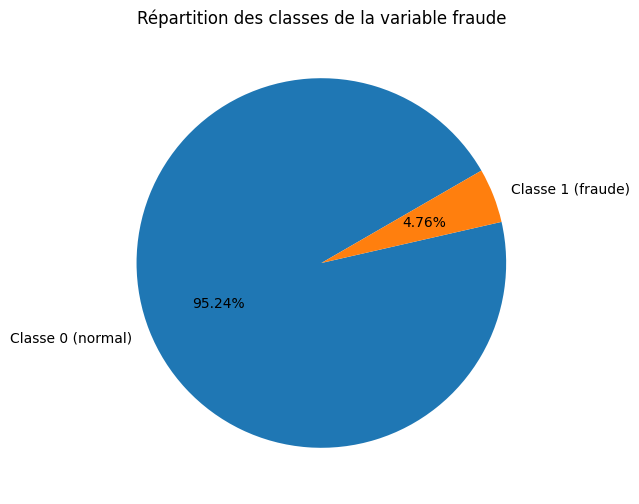

In [90]:
fraud_trans = df.loc[df['fraude'] == 1]
percentage_tot_fraud_trans = (len(fraud_trans) / tot_trans) * 100

print('Nombre de transaction totale: ', tot_trans)
print('Nombre de transaction frauduleuse: ', len(fraud_trans))
print('Pourcentage de transaction frauduleuse: ', round(percentage_tot_fraud_trans, 3), '%')

plt.figure(figsize=(6,6))
plt.pie(
    df['fraude'].value_counts(),
    labels=['Classe 0 (normal)', 'Classe 1 (fraude)'],
    autopct='%1.2f%%',
    startangle=30
)
plt.title("Répartition des classes de la variable fraude")
plt.show()



Dans l'ensemble des transactions effectuées, Il est clair qu'a première vue que nous avons très peu qui on été identifiées comme frauduleuses, soit *4.76%* de toutes les données.   

### Question 1.3 (1 point)

**Vérifiez la présence de valeurs manquantes dans le jeu de données et indiquez, pour chaque variable, le nombre de valeurs manquantes éventuelles.**

In [91]:
missing_values = df.isnull().sum()
print("Le nombre de valeurs manquantes pour chaque variables est: \n")
print(missing_values)

Le nombre de valeurs manquantes pour chaque variables est: 

transaction_id             0
date_heure                 0
client_id                  0
produit_id                 0
catégorie                  0
quantité                   0
prix_unitaire              0
moyen_paiement             0
ville                      0
âge_client                 0
ancienneté_compte_jours    0
fraude                     0
montant_total              0
dtype: int64


### Question 1.4 (3 points)

**Affichez des statistiques descriptives (moyenne, médiane, minimum, maximum, écart-type) pour les variables numériques, et visualisez-les à l’aide de boxplots.**

**Note** : Comme les variables peuvent avoir des échelles très différentes, assurez-vous de tracer les boxplots dans des graphiques séparés afin d’obtenir une visualisation claire et interprétable.

,variable,mean,median,min,max,std
0,quantité,3.718,3.00,1.00,95.00,6.672
1,prix_unitaire,135.683,103.13,10.04,4995.62,343.410
2,âge_client,43.890,44.00,18.00,69.00,14.591
3,ancienneté_compte_jours,491.700,495.00,1.00,999.00,286.730
4,montant_total,428.653,256.63,10.96,12517.05,904.876


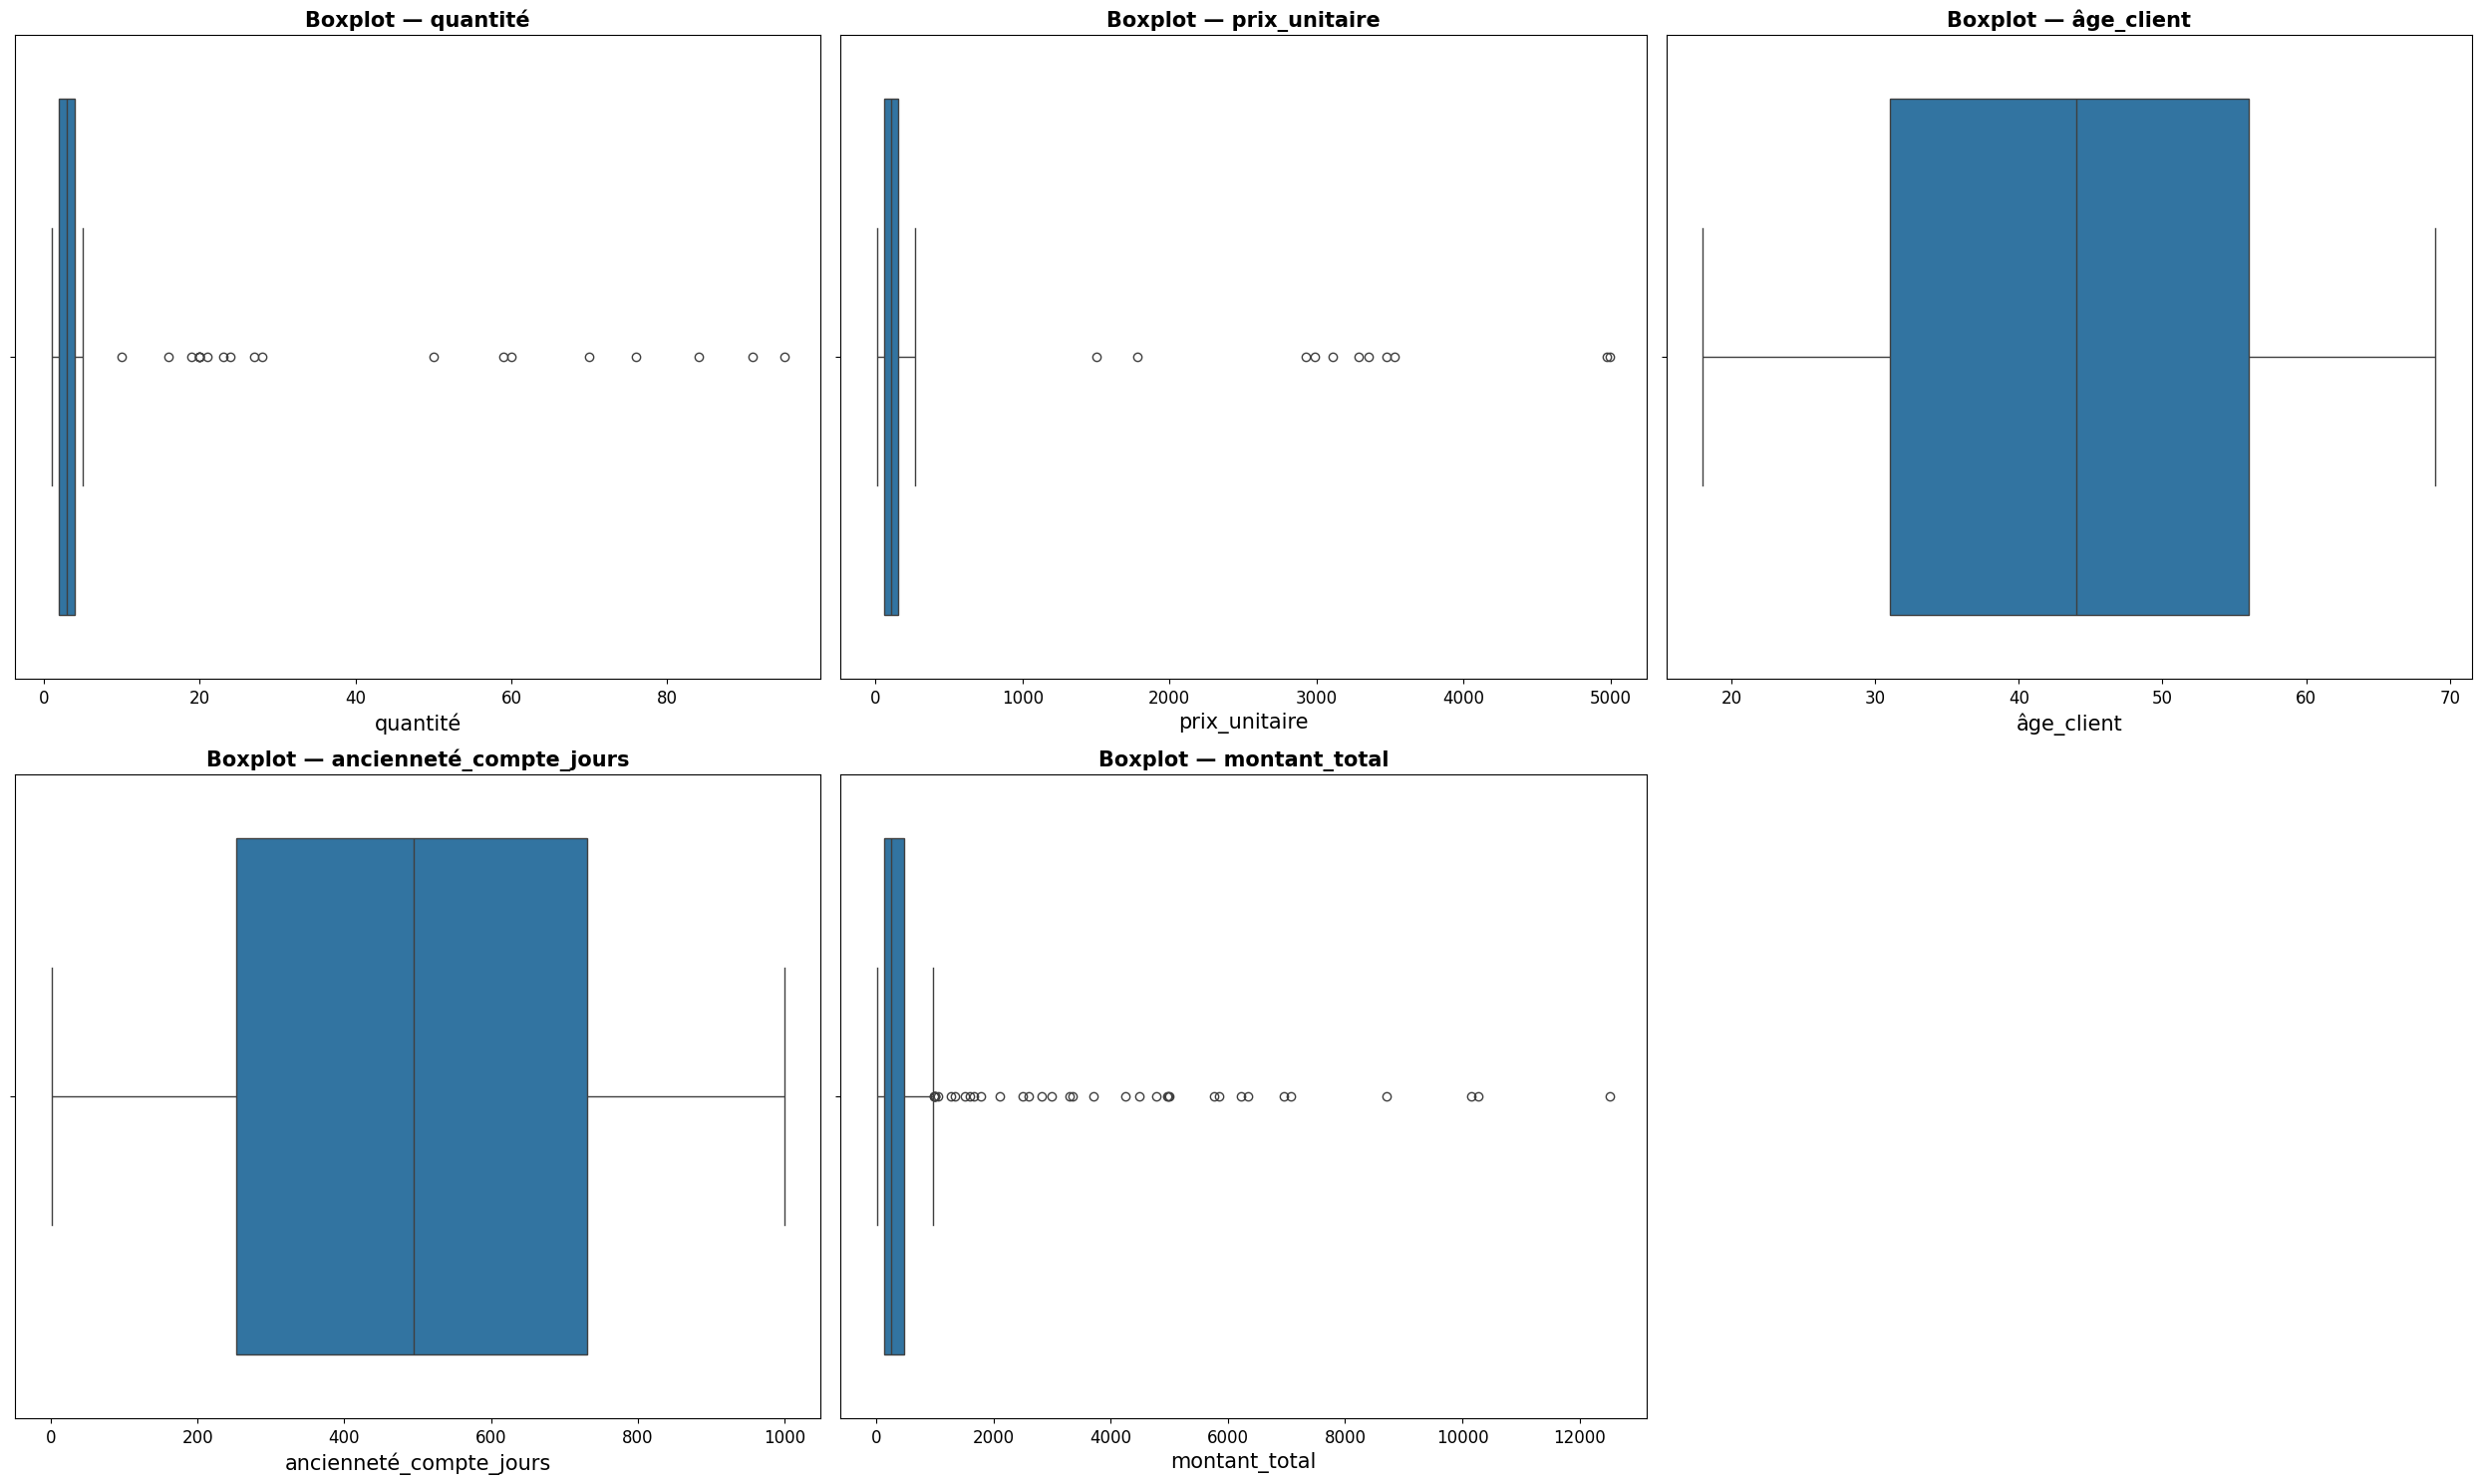

In [92]:
# On considère que fraude est une valeur booléen (classe 1 ou classe 0)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['fraude', 'transaction_id'])

stats = df[numeric_cols].agg(['mean', 'median', 'min', 'max', 'std']).T
stats = stats.reset_index().rename(columns={'index': 'variable'})
stats = stats.round(3)
display(stats)

row_count = math.ceil(len(numeric_cols) / 3)
fig, axes = plt.subplots(nrows=row_count, ncols=3, figsize=(25, 15))
axes = axes.flatten()

for i,col in enumerate(numeric_cols):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot — {col}', fontsize=15, fontweight='bold')
    axes[i].set_xlabel(f"{col}", fontsize=15)
    axes[i].tick_params(axis='x', labelsize=12)


for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.tight_layout()
plt.show()

### Question 1.5 (2 points)

**Pour les variables catégorielles, affichez les valeurs uniques, puis visualisez la répartition des catégories (en pourcentage) avec un pie chart ou un countplot. Veuillez exclure les variables de type ID de cette analyse.**

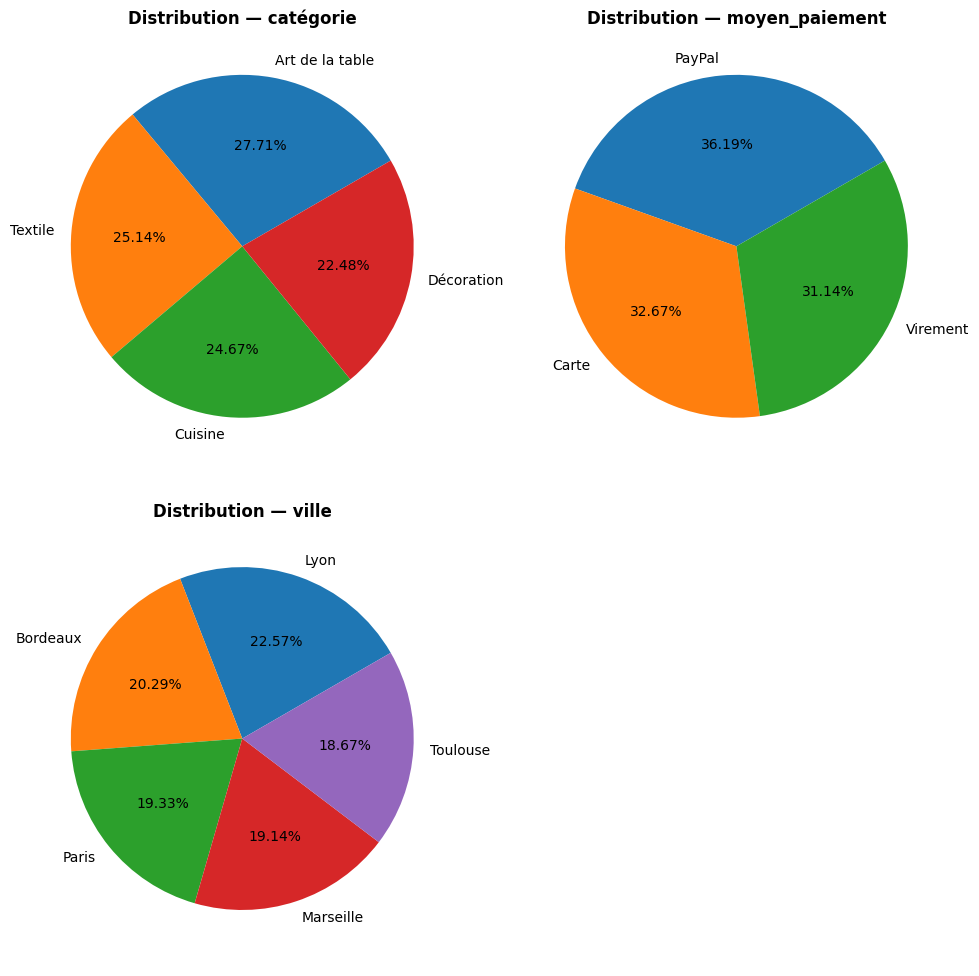

In [93]:
categoric_cols = df.select_dtypes(include=['object']).columns.drop(['client_id', 'produit_id', 'date_heure'])

row_count = math.ceil(len(categoric_cols) / 2)
fig, axes = plt.subplots(nrows=row_count, ncols=2, figsize=(10, 10))
axes = axes.flatten()

for i,col in enumerate(categoric_cols):
    counts = df[col].value_counts(normalize=True) * 100  
    axes[i].pie(
        counts,
        labels=counts.index,
        autopct='%1.2f%%',
        startangle=30
    )
    axes[i].set_title(f'Distribution — {col}', fontsize=12, fontweight='bold')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
fig.tight_layout()
plt.show()


## Partie 2 : Détection d'Anomalies Simple (10 points)

### Question 2.1 (5 points)

Implémentez la fonction `detect_anomalies_zscore` qui identifie et retourne les observations considérées comme des anomalies en se basant sur la méthode du **Z-Score**.

La fonction devra prendre en entrée un DataFrame \(data\), le nom de la colonne à analyser \(column\), et un seuil \(threshold\) (par défaut à 3).

Les observations dont la valeur absolue du Z-Score dépasse ce seuil seront considérées comme des anomalies.


In [94]:
def detect_anomalies_zscore(data, column, threshold=3):
    """
    Détecte les anomalies avec la méthode du Z-Score.

    Paramètres
    ----------
    data : DataFrame
        Données d’entrée.
    column : str
        Colonne cible.
    threshold : float
        Seuil Z-Score.

    Retourne
    --------
    DataFrame
        Lignes anormales.
    """
    df_copy = data.copy()

    mean = df_copy[column].mean()
    std = df_copy[column].std()

    df_copy['Z-score'] = (df_copy[column] - mean) / std

    data_anomalies = df_copy.loc[df_copy['Z-score'] >= threshold].copy()

    df_copy.drop(columns=['Z-score'], inplace=True)
    data_anomalies.drop(columns=['Z-score'], inplace=True)

    return data_anomalies

**Appliquez la fonction aux colonnes `montant_total` et `quantité`**.

In [95]:
detected_anomalies_montant = detect_anomalies_zscore(df, 'montant_total')

print('Transactions considérées comme anomalies (en fonction de montant_total): ')
detected_anomalies_montant.head()



Transactions considérées comme anomalies (en fonction de montant_total): 


,transaction_id,date_heure,client_id,produit_id,catégorie,quantité,prix_unitaire,moyen_paiement,ville,âge_client,ancienneté_compte_jours,fraude,montant_total
1000,20000,2023-05-24 00:00:00,C3010,P558,Décoration,1,4978.38,Virement,Lyon,69,585,1,4978.38
1001,20001,2023-05-01 00:00:00,C3016,P594,Textile,27,213.56,PayPal,Bordeaux,66,1,1,5766.12
1004,20004,2023-06-25 00:00:00,C3331,P567,Cuisine,1,3287.59,Carte,Lyon,62,447,1,3287.59
1005,20005,2023-06-09 00:00:00,C3811,P585,Textile,2,2927.98,Virement,Lyon,39,528,1,5855.96
1006,20006,2023-06-26 00:00:00,C3573,P581,Cuisine,91,137.55,PayPal,Lyon,40,359,1,12517.05


In [96]:
detected_anomalies_quant = detect_anomalies_zscore(df, 'quantité')
print('Transactions considérées comme anomalies (en fonction de quantité): ')
detected_anomalies_quant.head()

Transactions considérées comme anomalies (en fonction de quantité): 


,transaction_id,date_heure,client_id,produit_id,catégorie,quantité,prix_unitaire,moyen_paiement,ville,âge_client,ancienneté_compte_jours,fraude,montant_total
1001,20001,2023-05-01 00:00:00,C3016,P594,Textile,27,213.56,PayPal,Bordeaux,66,1,1,5766.12
1002,20002,2023-06-22 00:00:00,C3973,P543,Cuisine,24,66.75,PayPal,Toulouse,58,2,1,1602.00
1006,20006,2023-06-26 00:00:00,C3573,P581,Cuisine,91,137.55,PayPal,Lyon,40,359,1,12517.05
1010,20010,2023-06-06 00:00:00,C3467,P597,Décoration,70,145.11,PayPal,Lyon,23,635,1,10157.70
1011,20011,2023-06-27 00:00:00,C3855,P512,Cuisine,28,75.24,Virement,Marseille,45,1,1,2106.72


### Question 2.2 (5 points)

Implémentez la fonction `evaluate_performance` qui évalue la performance d'un modèle de détection d'anomalies.  

La fonction devra prendre en entrée les anomalies détectées et les vraies anomalies, puis calculer :  
- le nombre de vrais positifs et faux positifs,  
- la précision :  
  $
  \text{Precision} = \frac{VP}{VP + FP}
  $
- le rappel :  
  $
  \text{Rappel} = \frac{VP}{\text{Total Fraudes}}
  $

Elle retournera ces valeurs sous forme d'un dictionnaire pour analyser la qualité de la détection.



In [97]:
def evaluate_performance(anomalies_detectees, vraies_anomalies):
    """
    Évalue la performance de détection.

    Paramètres
    ----------
    anomalies_detectees : DataFrame
        Anomalies prédites.
    vraies_anomalies : DataFrame
        Anomalies réelles.

    Retourne
    --------
    dict
        Métriques d’évaluation.
    """
    pred_ids = set(anomalies_detectees['transaction_id'])
    true_ids = set(vraies_anomalies['transaction_id'])

    vp_ids = pred_ids & true_ids
    VP = len(vp_ids)

    fp_ids = pred_ids - true_ids
    FP = len(fp_ids)

    total_fraudes = len(true_ids)

    precision = round(VP / (VP + FP), 3) 
    recall = round(VP / total_fraudes, 3) 

    return {'precision': precision, 'rappel': recall}

**Appliquez la fonction aux colonnes `montant_total` et `quantité`. Commentez brièvement.**

In [98]:
fraud_trans = df.loc[df['fraude'] == 1]

## En fonction de quantié
performance_quant = evaluate_performance(detected_anomalies_quant, fraud_trans)
print('Performance du modèle (en fonction de quantité): ', performance_quant)

## En fonction de montant_total
performance_montant = evaluate_performance(detected_anomalies_montant, fraud_trans)
print('Performance du modèle (en fonction de montant): ', performance_montant)

Performance du modèle (en fonction de quantité):  {'precision': 1.0, 'rappel': 0.22}
Performance du modèle (en fonction de montant):  {'precision': 1.0, 'rappel': 0.38}


Dans les deux cas (pour `quantité` et `montant`), le modèle nous donne une précision de parfait, soit **1**, ce qui signifie qu'il génére seulement de vraies anomalies. Cependant, le rappel est faible (**0.22** et **0.38**), ce qui indique que le modèle ne détecte qu’une petite partie des fraudes réelles. Bref, sous un seuil de 3 pour le Z-score, le modèle signale uniquement les fraudes les plus évidentes et en laisse passer beaucoup d'autre.

## Partie 3 : Détection d'Anomalies par Clustering (20 points)

### Question 3.1 (5 points)

Implémentez la fonction `preprocess_data` qui encode les variables catégorigues en utilisant le One-Hot Encoding et standardize les variables numériques.

**NB 1:** Les variables suivantes doivent être exclues: `date_heure`,
`client_id`, `produit_id`, `transaction_id` et `fraude`.

**NB 2:** Après l'encodage, supprimez la colonne correspondant à la première modalité de chaque variable catégorique pour éviter la multicolinéarité.

Affichez le nombre de colonnes et le type de chaque colonne avant et après le pré-traitement.

In [158]:
def preprocess_data(df):
    """
    Prépare les données pour l’analyse.

    Paramètres
    ----------
    df : DataFrame
        Données brutes.

    Retourne
    --------
    DataFrame
        Données prétraitées.
    """
    new_df = df.drop(columns=['date_heure', 'client_id', 'produit_id', 'transaction_id', 'fraude'])
    print("=== AVANT PRÉTRAITEMENT ===")
    print("Nombre de colonnes :", new_df.shape[1])
    print(new_df.dtypes)

    categoric_cols = new_df.select_dtypes(include=['object', 'category']).columns
    numeric_cols = new_df.select_dtypes(include=['int64', 'float64']).columns

    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded = encoder.fit_transform(new_df[categoric_cols])
    encoded_cols = encoder.get_feature_names_out(categoric_cols)
    df_encoded = pd.DataFrame(encoded, columns=encoded_cols, index=new_df.index)


    scaler = StandardScaler()
    scaled_numeric = scaler.fit_transform(new_df[numeric_cols])
    df_numeric = pd.DataFrame(scaled_numeric, columns=numeric_cols, index=new_df.index)

    preprocessed_df = pd.concat([df_numeric, df_encoded], axis=1)

    print("\n=== APRÈS PRÉTRAITEMENT ===")
    print("Nombre de colonnes :", preprocessed_df.shape[1])
    print(preprocessed_df.dtypes)
    return preprocessed_df

In [165]:
preprocessed_df = preprocess_data(df)

=== AVANT PRÉTRAITEMENT ===
Nombre de colonnes : 8
catégorie                   object
quantité                     int64
prix_unitaire              float64
moyen_paiement              object
ville                       object
âge_client                   int64
ancienneté_compte_jours      int64
montant_total              float64
dtype: object

=== APRÈS PRÉTRAITEMENT ===
Nombre de colonnes : 14
quantité                   float64
prix_unitaire              float64
âge_client                 float64
ancienneté_compte_jours    float64
montant_total              float64
catégorie_Cuisine          float64
catégorie_Décoration       float64
catégorie_Textile          float64
moyen_paiement_PayPal      float64
moyen_paiement_Virement    float64
ville_Lyon                 float64
ville_Marseille            float64
ville_Paris                float64
ville_Toulouse             float64
dtype: object


### Question 3.2 (5 points)

Déterminez le nombre optimal de clusters pour vos données prétraitées ``preprocessed_df`` en utilisant la méthode du score de silhouette avec ``KMeans``.

Pour faire ceci, testez les valeurs de $k$ comprises entre 2 et 10 et tracez le score de silhouette en fonction du nombre de clusters.  
Indiquez ensuite la valeur de $k$ qui maximise ce score.

**NB** : Lorsque vous utilisez ``KMeans``, ajoutez les paramètres ``random_state=42`` pour la reproductibilité des résultats, et ``n_init=10`` pour augmenter les chances d’obtenir un bon clustering (``KMeans`` est lancé 10 fois avec des initialisations différentes des centres pour garder la meilleure solution à la fin.).

Nombre optimal de clusters : 2
Score de silhouette maximal : 0.764


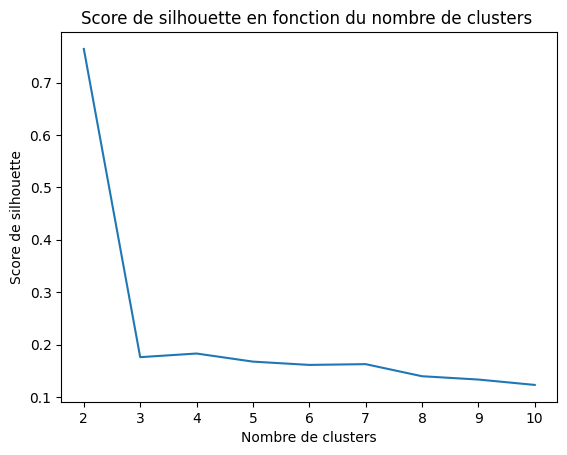

In [102]:
scores = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(preprocessed_df)
    score = silhouette_score(preprocessed_df, cluster_labels)
    scores.append(score)

plt.title("Score de silhouette en fonction du nombre de clusters ")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette")
plt.plot(range(2,11), scores)

best_k = range(2,11)[scores.index(max(scores))]
print("Nombre optimal de clusters :", best_k)
print("Score de silhouette maximal :", round(max(scores), 3))


**Comparez le nombre optimal de clusters obtenu avec le nombre de classes dans la colonne `fraude`. Que remarquez-vous?**

Le nombre optimal de clusters (k = 2) correspond au nombre de classes dans fraude (classe 0 ou classe 1). Cela démontre alors que les données sont dispersées naturellement pour former deux groupes distincts, ce qui reflète bien la séparation entre transactions normales et frauduleuses.

### Question 3.3 (5 points)

Appliquez `KMeans` avec le nombre de clusters $k$ retenu.  
Calculez ensuite le score d'outlier de chaque point en utilisant la distance de Mahalanobis.

La distance de Mahalanobis d'un point $X_i$ par rapport à son cluster $r$ est donnée par :

$$
\text{Maha}(X_i, \mu_r, \Sigma_r) = \sqrt{(X_i - \mu_r) \, \Sigma_r^{-1} \, (X_i - \mu_r)^T}
$$

où :  
- $X_i$ : point considéré  
- $\mu_r$ : centroïde du cluster $r$  
- $\Sigma_r$ : matrice de covariance des points dans le cluster $r$. Si $\Sigma_r$ n’est pas inversible, utilisez son pseudo-inverse.

In [103]:
# Dans notre cas, best_k = 2
kmeans = KMeans(n_clusters=best_k, )
cluster_labels = kmeans.fit_predict(preprocessed_df)

df_clustered = preprocessed_df.copy()
df_clustered['cluster'] = cluster_labels

mahalanobis_distances = []
for cluster in np.unique(cluster_labels):
    X = df_clustered.loc[df_clustered['cluster'] == cluster].drop(columns=['cluster']).values
    centroid = np.mean(X, axis=0)

    cov = np.cov(X, rowvar=False)

    for x_i in X:
        cov_inv = np.linalg.pinv(cov)
        mahalanobis_dist = mahalanobis(x_i, centroid, cov_inv)
        mahalanobis_distances.append(mahalanobis_dist)

**Affichez la distribution des distances de Mahalanobis.**

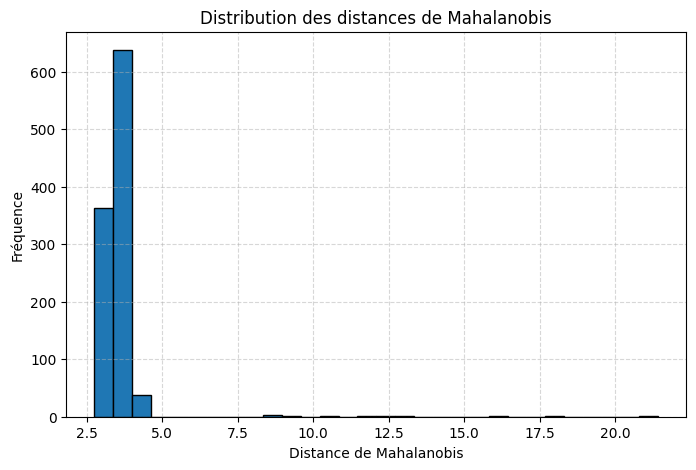

In [104]:
df_clustered['mahalanobis_distance'] = mahalanobis_distances

plt.figure(figsize=(8,5))
plt.hist(df_clustered['mahalanobis_distance'], bins=30, edgecolor='black')
plt.title("Distribution des distances de Mahalanobis")
plt.xlabel("Distance de Mahalanobis")
plt.ylabel("Fréquence")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Question 3.4 (5 points)

À partir des scores de Mahalanobis calculés pour chaque point :  

1. Déterminez un seuil d’anomalie correspondant au 95ème percentile des distances.  
2. Détectez les points considérés comme anomalies en utilisant ce seuil (valeurs supérieures strictement).  
3. Évaluez la performance de la détection en comparant les anomalies détectées avec la colonne `fraude`.  
   - Calculez le nombre de vrais positifs, faux positifs, précision, rappel et F1-Score.
   - Commentez vos résultats.

In [105]:
seuil_95 = np.percentile(df_clustered['mahalanobis_distance'], 95)

df_clustered['anomalie'] = df_clustered['mahalanobis_distance'] > seuil_95
df_clustered['fraude'] = df['fraude']

VP = np.sum((df_clustered['anomalie'] == True) & (df_clustered['fraude'] == 1))
FP = np.sum((df_clustered['anomalie'] == True) & (df_clustered['fraude'] == 0))

FN = np.sum((df_clustered['anomalie'] == False) & (df_clustered['fraude'] == 1))

precision = VP / (VP + FP) 
recall = VP / (VP + FN) 
f1 = (2 * precision * recall) / (precision + recall)

print("VP :", VP)
print("FP :", FP)
print("FN :", FN)
print("Precision :", round(precision, 3))
print("Recall :", round(recall, 3))
print("F1-Score :", round(f1, 3))


VP : 17
FP : 36
FN : 33
Precision : 0.321
Recall : 0.34
F1-Score : 0.33


La distance de Mahalanobis est capable d'identifier certains cas fortement anormales, mais manque une grande partie des fraudes réelles, soit **17** frauduleuses prédites et **33** transactions de fraude manquées. De plus, elle génère aussi un grand nombre faux positifs **(FN = 36)**. Globalement, cette méthode offre une détection modérée de fraude avec un F1-score de **0.33**.

Bref, cela indique que cette méthode seule n’est pas suffisante pour faire une détection de fraude efficace. Cependant, à elle seule, on peut facilement détecter des anomalies extrêmes.

## Partie 4 : Méthodes basées sur reconstruction (30 points)

Pour cette partie, vous allez implémenter un autoencodeur, un modèle d'apprentissage profond, pour repérer les comportements inhabituels dans les données.
L’objectif est de permettre au modèle d’apprendre la structure sous-jacente des transactions normales et de mettre en évidence celles qui s’en écartent significativement, indiquant ainsi une possible anomalie.

**NB** : Il s'agit d'un modèle d'apprentissage non supervisé, c'est-à-dire que les étiquettes indiquant la fraude (0 ou 1) ne doivent pas être utilisées pendant la phase d'entraînement.

### Question 4.1 (3 points)

Séparez les données (encodées et standardisées) en sous-ensemble d'entraînement et de test. Procédez comme suit :
* Utilisez 80 % des données non frauduleuses pour constituer l’ensemble d’entraînement.
* Conservez 20 % des données non frauduleuses pour l’ensemble de test.
* Ajoutez toutes les données frauduleuses à l’ensemble de test.

In [ ]:
# Rajouter la colonne fraude qui avait été exclues pour la partie 3
if 'fraude' not in preprocessed_df.columns:
    cols = df[['fraude']].reset_index(drop=True)
    preprocessed_df = pd.concat([preprocessed_df.reset_index(drop=True), cols], axis=1)
    
non_fraud = preprocessed_df[preprocessed_df['fraude'] == 0].copy()
fraud = preprocessed_df[preprocessed_df['fraude'] == 1].copy()

train_df, test_normal = train_test_split(non_fraud, test_size=0.2, random_state=42)
test_df = pd.concat([test_normal, fraud], axis=0).reset_index(drop=True)


### Question 4.2 (10 points)

Complétez la classe `Autoencoder` fournie. L'architecture du modèle doit respecter la structure suivante :
* Couche d'entrée :
  * Dimension égale au nombre de features du dataset `input_dim`.
* Encodeur :
  * Couche Dense avec `hidden_dim1` neurones, activation ReLU.
  * Batch Normalization.
  * Dropout avec un taux `dropout_rate` pour réduire le surapprentissage.
  * Couche Dense avec `hidden_dim2` neurones, activation ReLU.
  * Couche Dense avec `encoding_dim` neurones, activation ReLU.
* Décodeur (symétrique à l’encodeur), pas de normalisation batch ni de dropout.
  * Couche Dense avec `hidden_dim2` neurones, activation ReLU.
  * Couche Dense avec `hidden_dim1` neurones, activation ReLU.
  * Couche Dense avec `input_dim` neurones, activation linéaire.
* Compilez le modèle avec :
  * Optimiseur : Adam
  * Taux d’apprentissage : valeur passée en paramètre `learning_rate`
  * Fonction de perte : MSE (Mean Squared Error)
  * Métrique : MAE (Mean Absolute Error)

In [144]:
class Autoencoder:

    def __init__(self, input_dim, encoding_dim=7, hidden_dim1=32, hidden_dim2=16, learning_rate=0.001, dropout_rate=0.1):
        """
        Initialisation de l'autoencodeur.

        Paramètres
        ----------
        input_dim : int
            Dimension des données d'entrée.
        encoding_dim : int
            Dimension de l'espace latent (bottleneck).
        hidden_dim1 : int
            Taille de la première couche cachée.
        hidden_dim2 : int
            Taille de la deuxième couche cachée.
        learning_rate : float
            Taux d'apprentissage.
        dropout_rate : float
            Taux de dropout pour la régularisation.
        """
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate

        self.model = None

        self._build_autoencoder()

    def _build_autoencoder(self):
        """Construction de l'architecture de l'autoencodeur."""
        # Couche d'entrée
        input_layer = Input(shape=(self.input_dim,))

        # Encodeur

        # - première couche
        x = Dense(self.hidden_dim1, activation='relu')(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(self.dropout_rate)(x)

        # deuxième couche
        x = Dense(self.hidden_dim2, activation='relu')(x)
        # troisème couche
        encoded = Dense(self.encoding_dim, activation='relu')(x)

        # Décodeur
        # TO DO
        # - première couche
        x = Dense(self.hidden_dim2, activation='relu')(encoded)

        # deuxième couche
        x = Dense(self.hidden_dim1, activation='relu')(x)
        # troisème couche
        decoded = Dense(self.input_dim)(x)

        # Modèle complet
        self.model = Model(inputs=input_layer, outputs=decoded) 

        # Compilation
        adam_optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])

    def summary(self):
        """Affiche le résumé du modèle complet."""
        return self.model.summary()

**Initialisez l'autoencodeur et vérifier que vous avez la bonne structure en affichant le `summary`. Vous disposez du résultats attendu dans la cellule suivante.**

In [181]:
train_df = train_df.drop(columns=['fraude'])
nb_features = len(train_df.columns)
autoencoder = Autoencoder(input_dim=nb_features)
autoencoder.summary()



Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 7)              │           119 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 16)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,389 (9.33 KB)

 Trainable params: 2,325 (9.08 KB)

 Non-trainable params: 64 (256.00 B)

| Layer (type)                    | Output Shape | Param # |
|---------------------------------|--------------|---------|
| input_layer (InputLayer)        | (None, 14)   | 0       |
| dense (Dense)                   | (None, 32)   | 480     |
| batch_normalization (BatchNormalization) | (None, 32) | 128 |
| dropout (Dropout)               | (None, 32)   | 0       |
| dense_1 (Dense)                 | (None, 16)   | 528     |
| dense_2 (Dense)                 | (None, 7)    | 119     |
| dense_3 (Dense)                 | (None, 16)   | 128     |
| dense_4 (Dense)                 | (None, 32)   | 544     |
| dense_5 (Dense)                 | (None, 14)   | 462     |


### Question 4.3 (3 points)

Entraînez l’autoencodeur sur 50 époques en utilisant des lots de taille 32. Réservez 10% des données pour la validation **avec** mélange aléatoire (shuffle) des échantillons à chaque époque.

In [182]:
X_train = train_df.values

results = autoencoder.model.fit(
    X_train,
    X_train,                
    epochs=50,
    batch_size=32,
    validation_split=0.1,    
    shuffle=True,            
    verbose=1
)

Epoch 1/50


2025-11-23 21:27:08.933479: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3100 - mae: 0.3675 - val_loss: 0.2850 - val_mae: 0.3309
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2684 - mae: 0.3587 - val_loss: 0.2653 - val_mae: 0.3426
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2454 - mae: 0.3597 - val_loss: 0.2457 - val_mae: 0.3428
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2182 - mae: 0.3501 - val_loss: 0.2226 - val_mae: 0.3357
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1929 - mae: 0.3351 - val_loss: 0.1983 - val_mae: 0.3240
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1731 - mae: 0.3215 - val_loss: 0.1797 - val_mae: 0.3154
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1586 - mae: 0.3105 - val_loss: 0.1652 - val_mae: 0.3074
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1486 - mae: 0.3031 - val_loss: 0.1533 - val_mae: 0.3010
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1392 - mae: 0.2953 - va

Tracez, sur un même graphique, les courbes de perte de l’autoencodeur pour l’entraînement et la validation en fonction des époques. Commentez brièvement.

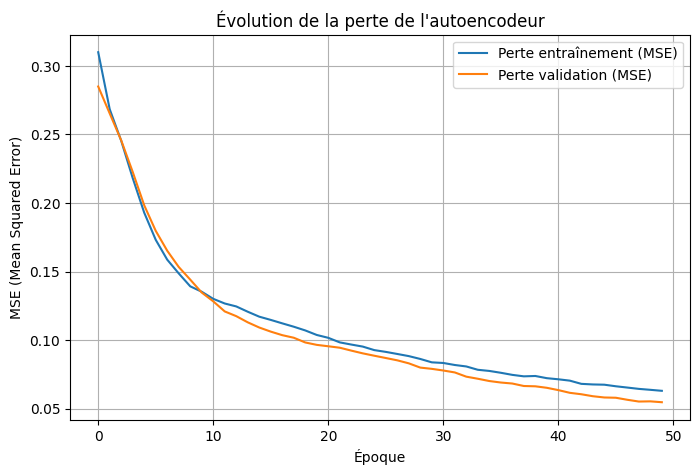

In [183]:
plt.figure(figsize=(8,5))
plt.plot(results.history['loss'], label='Perte entraînement (MSE)')
plt.plot(results.history['val_loss'], label='Perte validation (MSE)')

plt.title("Évolution de la perte de l'autoencodeur")
plt.xlabel("Époque")
plt.ylabel("MSE (Mean Squared Error)")
plt.legend()
plt.grid(True)
plt.show()

Les courbes de perte d’entraînement et de validation diminuent graduellement au fil des époques, ce qui indique que l’autoencodeur apprend à reconstruire correctement les données normales. De plus, la perte de validation et la perte d'entraînement ont des courbes similaires, ce qui explique que le modèle généralise bien les résulats.

Bref, on peut dire que le modèle n'est pas dans un état de surapprentissage et donc il est capable de reproduire correctement de nouvelles données.

### Question 4.4 (4 points)

L'erreur reconstruction de l'autoencodeur pour chaque donnée est calculée comme suit :\
$
\text{Erreur}_i = \sqrt{\sum_{k=1}^{d} (x_{ik} - \hat{x}_{ik})^2} = \| X_i - \hat{X}_i \|_2
$
où :
- $i$ est l'indice du point,  
- $d$ est le nombre de dimensions,  
- ${x}_{ik}$ est la valeur originale du point.
- $\hat{x}_{ik}$ est sa reconstruction par le modèle.

Calculez et affichez les erreurs de reconstruction pour les données de test.

In [184]:
X_test  = test_df.drop(columns=['fraude']).values
X_test_reconstructions = autoencoder.model.predict(X_test)

reconstruction_errors = np.linalg.norm(X_test - X_test_reconstructions, axis=1)

errors_df = test_df.copy()
errors_df['reconstruction_error'] = reconstruction_errors

display(errors_df.head())

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


2025-11-23 21:27:20.501622: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


,quantité,prix_unitaire,âge_client,ancienneté_compte_jours,montant_total,catégorie_Cuisine,catégorie_Décoration,catégorie_Textile,moyen_paiement_PayPal,moyen_paiement_Virement,ville_Lyon,ville_Marseille,ville_Paris,ville_Toulouse,fraude,reconstruction_error
0,-0.107682,-0.088984,-1.295178,1.250205,-0.125196,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.825886
1,-0.107682,-0.026289,0.281839,0.573287,-0.053815,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.859552
2,-0.107682,-0.146436,-0.678084,-0.934077,-0.190606,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.403216
3,-0.257637,0.002845,0.144707,0.646561,-0.171744,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.735541
4,-0.107682,-0.293910,1.241761,-1.234154,-0.358510,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0.681598


Affichez deux histogrammes représentant la distribution des erreurs de reconstruction : l’un pour les données normales, l’autre pour les données frauduleuses.
Comparez visuellement les deux distributions et commentez brièvement les différences observées.

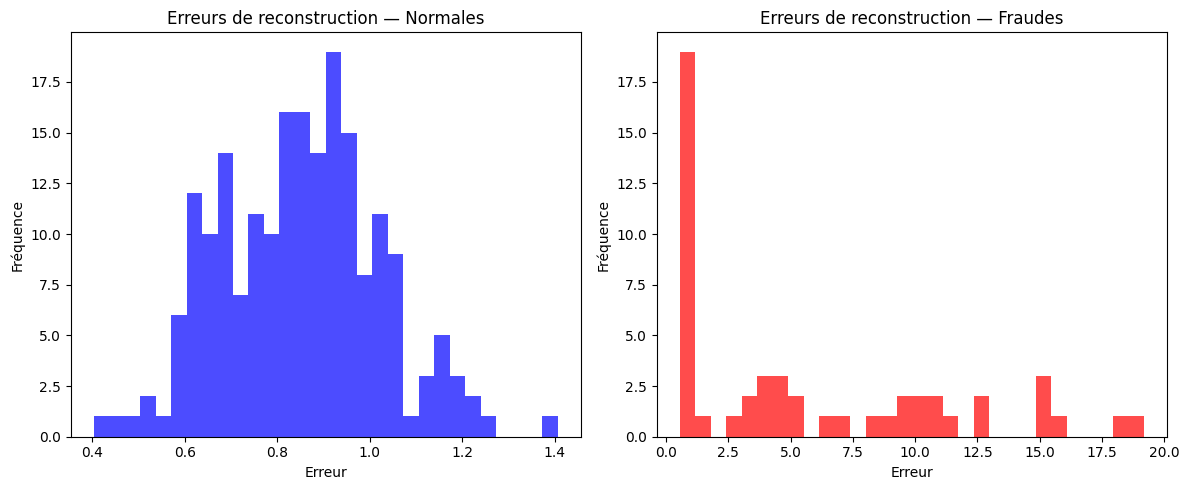

In [186]:
errors_normal = errors_df[errors_df['fraude'] == 0]['reconstruction_error']
errors_fraud  = errors_df[errors_df['fraude'] == 1]['reconstruction_error']

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist(errors_normal, bins=30, alpha=0.7, color='blue')
plt.title("Erreurs de reconstruction — Normales")
plt.xlabel("Erreur")
plt.ylabel("Fréquence")

plt.subplot(1, 2, 2)
plt.hist(errors_fraud, bins=30, alpha=0.7, color='red')
plt.title("Erreurs de reconstruction — Fraudes")
plt.xlabel("Erreur")
plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

Les erreurs de reconstruction des transactions normales sont similaire et globalement faibles, soit entre **0.4** et **1,4**, ce qui démontre que l’autoencodeur reconstruit bien les comportements habituels. Cependant, les transactions frauduleuses présentent des erreurs beaucoup plus élevées et dispersées. Cette différence entre les deux distributions nous indique alors que l’erreur de reconstruction permet effectivement de déterminer si une transaction est frauduleuse ou non, car, selon le modèle, elle ne ferait pas partie de la distribution normale des données  


### Question 4.5 (4 points)

Pour détecter les anomalies à partir des erreurs de reconstruction, nous devons choisir un seuil qui permet de distinguer au mieux les données normales des données frauduleuses.

1. Utilisez la fonction `precision_recall_curve` de `scikit-learn` pour calculer la précision et le rappel pour différents seuils appliqués aux erreurs de reconstruction. (Nous comparons les erreurs de reconstruction avec les étiquettes réelles $y_{test}$).
2. À partir de ces valeurs, calculez le F1-score pour chaque seuil :
$
\text{F1-score} = \frac{2 \times \text{Précision} \times \text{Rappel}}{\text{Précision} + \text{Rappel}}
$
3. Identifiez le seuil optimal qui maximise le F1-score.  
4. Tracez sur le même graphique les courbes de précision, rappel et f1-score puis indiquez le seuil optimal sur le graphique.

Seuil optimal : 1.7367175971104927
F1-score optimal : 0.7654320987654321


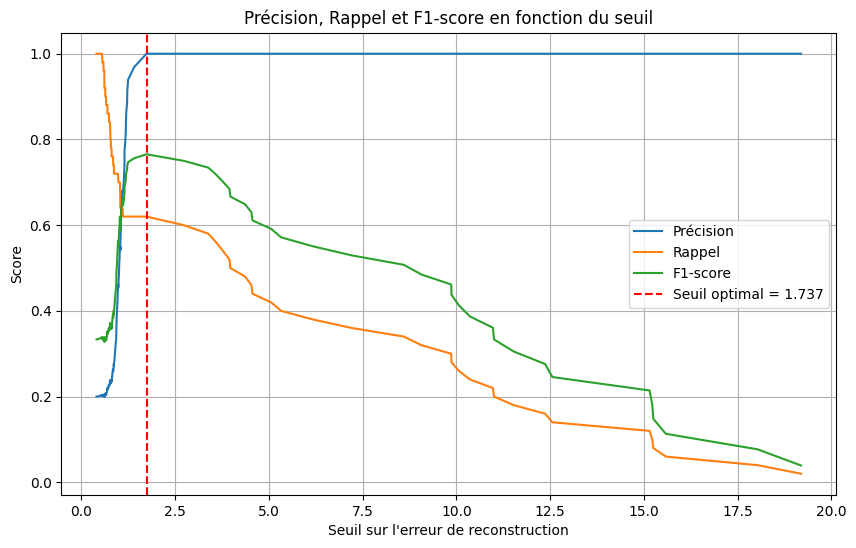

In [ ]:
y_test = test_df['fraude'].values

precisions, recalls, thresholds = precision_recall_curve(y_test, reconstruction_errors)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print("Seuil optimal :", best_threshold)
print("F1-score optimal :", best_f1)

plt.figure(figsize=(10, 6))

plt.plot(thresholds, precisions[:-1], label='Précision')
plt.plot(thresholds, recalls[:-1], label='Rappel')
plt.plot(thresholds, f1_scores[:-1], label='F1-score')

plt.axvline(best_threshold, color='red', linestyle='--', label=f'Seuil optimal = {best_threshold:.3f}')

plt.xlabel("Seuil sur l'erreur de reconstruction")
plt.ylabel("Score")
plt.title("Précision, Rappel et F1-score en fonction du seuil")
plt.legend()
plt.grid(True)
plt.show()

### Question 4.6 (3 points)

Classez les observations du jeu de test en utilisant les erreurs de reconstruction et le seuil optimal déterminé précédemment. Si l’erreur dépasse ce seuil, l'observation est considérée comme anomalie. Affichez le rapport de classification et la matrice de confusion pour les données de test. Commentez brièvement.


In [ ]:
# TO DO

### Question 4.7 (3 points)

**Répondez aux questions suivantes :**
* Pourquoi utilise-t-on seulement les données normales pour l'entraînement ?
* Quelle est l'utilité de la couche bottleneck (encoding_dim) ?
* L'erreur de reconstruction est-elle un bon indicateur d'anomalie ? Justifiez votre réponse.

## Partie 5 : Etude d'ablation (20 points)

Dans cette partie, vous allez implémenter une étude d'ablation en utilisation votre autoencodeur. L'objectif est d’évaluer l’importance de chaque variable d’entrée du modèle. La méthodologie est simple: il faut retirer une variable à la fois, réentraîner l’autoencodeur, puis comparer la performance obtenue avec celle du modèle complet.

### Question 5.1 (5 points)

Complétez la fonction `evaluate_with_fixed_threshold`, dont la signature est fournie dans le code, pour évaluer la performance de l’autoencodeur en utilisant un seuil fixe pour la détection d’anomalies.
Cette fonction doit :  
- Calculer les erreurs de reconstruction pour chaque observation du jeu de test.  
- Classer les observations comme normales ou anomalies selon si leur erreur dépasse le seuil fixé.
- Calculer et retourner les principales métriques de performance : précision, rappel et F1-score.  

In [ ]:
# TO DO
def evaluate_with_fixed_threshold(autoencoder, X_test, y_test, threshold):
    """
    Évalue l'autoencodeur avec un seuil de décision fixé

    Paramètres:
    autoencoder: modèle autoencodeur entraîné
    X_test: données de test
    y_test: labels réels
    threshold: seuil fixe pour la détection d'anomalies

    Retourne:
    metrics: dictionnaire des métriques de performance
    """
    pass

### Question 5.2 (6 points)

Complétez la fonction `run_ablation_study_fixed_threshold` pour réaliser une étude d’ablation. Cette fonction doit :  
- Utiliser le modèle de référence (baseline) entraîné avec toutes les variables et évaluer sa performance avec le seuil fixe.  
- Répéter l’expérience en supprimant une variable à la fois du jeu de données :  
  - Initialiser et entraîner un nouvel autoencodeur sans la variable supprimée.
  - Évaluer le modèle avec le même seuil fixe.  
  - Mesurer l’impact de la suppression sur les métriques (en particulier le F1-score).  
- Retourner un `DataFrame` qui résume la baisse de performance pour chaque variable retirée. La première colonne doit contenir le nom de la variable supprimée. Les colonnes suivantes doivent présenter la différence entre les valeurs des métriques obtenues après la suppression de la variable et celles du modèle de base (baseline). Ajoutez également des colonnes contenant les valeurs absolues des métriques calculées.

In [ ]:
# TO DO
def run_ablation_study_fixed_threshold(autoencoder_baseline, X_train, X_test, y_test,
                                       feature_names, fixed_threshold):
    """
    Réalise une étude d'ablation avec seuil de décision fixe

    Paramètres:
    fixed_threshold: seuil fixe utilisé pour toutes les évaluations
    autoencoder_baseline: modèle de référence entraîné avec toutes les variables
    X_train: données d'entraînement
    X_test: données de test
    y_test: labels réels
    feature_names: liste des noms des variables
    encoding_dim: dimension de l'espace latent

    Retourne:
    ablation_results: DataFrame avec les résultats pour chaque variable retirée
    """
    pass

### Question 5.3 (3 points)

Exécutez l'étude d'ablation en utilisant la fonction `run_ablation_study_fixed_threshold` afin de mesurer l'importance des variables suivantes : `'quantité'`, `'prix_unitaire'`, `'montant_total'`, `'âge_client'`, `'ancienneté_compte_jours'`, et `'ecart_localisation'`. Utilisez votre meilleur seuil de la question $Q4.5$ et affichez le dataframe obtenu.

In [ ]:
# TO DO

### Question 5.4 (4 points)

Complétez la fonction `plot_ablation_results` pour visualiser les résultats de l'étude d'ablation. Cette fonction contient deux graphiques. Le premier montre la baisse du F1-score après la suppression de chaque variable. Le second affiche les valeurs absolues du F1-score obtenues après la suppression de chaque variable, avec une ligne en pointillés représentant le F1-score du modèle de base (baseline).  


In [ ]:
# TO DO
def plot_ablation_results(ablation_results, baseline_f1_score):
    """
    Visualise les résultats de l'étude d'ablation

    Paramètres:
    ablation_results: DataFrame avec les résultats pour chaque variable retirée
    baseline_f1_score: F1-score du modèle de base (baseline)
    """
    pass

In [ ]:
# TO DO

### Question 5.5 (2 points)

A partir du graphique précédent ou en utilisant du code, identifiez les variables dont la suppression entraîne une perte de 0.03 ou plus dans le F1-score. Commentez brièvement.

In [ ]:
# TO DO

## Partie 6 : Local Outlier Factor - LOF (10 points)

Pour la dernière partie du TP, vous allez détecter les anomalies frauduleuses en utilisant une technique basée sur la densité : **Facteur Local d’Aberration (Local Outlier Factor)**. Cette technique utilise la densité locale autour d’un point pour déterminer s’il est isolé par rapport à ses voisins proches. I.e., un point est considéré aberrant s'il est situé dans une région où la densité locale est nettement plus faible que celle de ses voisins, ce qui fait que son score LOF est plus élevé. Cette technique a donc l'avantage de pouvoir détecter les anomalies locales contrairement aux méthodes globales.
Pour calculer le facteur d'aberration d'un point $i$, il faut suivre les étapes suivantes :
1. Il faut identifier les k points les plus proches selon une distance (euclidienne dans le cadre du TP).
2. Il faut ensuite calculer la distance de portée (reachability distance) qui mesure à quel point le point $i$ est accessible à partir de ses voisins. La distance de portée entre les points $i$ et et l'un de ses voisin $j$ est définie comme la plus grande valeur entre la distance euclidienne $d(i,j)$ et la distance séparant $j$ de son $k$-ème plus proche voisin.\
$\text{RD(i,j)} = \max\left(d(i,j), \; d_k(j)\right)$

4. La troisième étape consiste à calculer la densité locale (Local Reachability Density – LRD) du point. Il s'agit de la moyenne des distances de portée entre le point en question et ses $k$ plus proches voisins.
5. Finalement, le facteur local d'aberration du point est calculé comme suit :
$
\text{LOF}(i) = \frac{\text{Moyenne des densités locales des voisins de} i}{\text{densité locale de } i}
$

**NB1:** Les formules mathématiques de chaque étape sont définies dans les questions associées.\
**NB2:** Les étapes 2 et 3 sont calculées conjointement dans la deuxième question.

**Sources**
- [Breunig, M. M., Kriegel, H. P., Ng, R. T., & Sander, J. (2000, May). LOF: identifying density-based local outliers. In Proceedings of the 2000 ACM SIGMOD international conference on Management of data (pp. 93-104).](https://doi.org/10.1145/342009.335388)
- [Explication pas-à-pas de l'algorithme LOF.](https://www.kaggle.com/discussions/general/183478)

### Question 6.1 (2 points)

Complétez les fonctions suivantes :
- `compute_distances` qui retourne une matrice carré contenant la distance euclidienne entre chaque paire de points.
- `find_k_neighbors` qui accèpte la matrice de distance calculée et le nombre de voisins souhaités et retourne pour chaque point les indices des ses $k$ plus proches voisins et la distance au $k$-ème voisin.

In [ ]:
def compute_distances(X):
    """
    Calcule la matrice de distance entre chaque paire de points.

    Paramètres:
    X: données d'entrée

    Retourne:
    matrice de distances
    """
    pass

In [ ]:
def find_k_neighbors(dist_matrix, k):
    """
    Identifie les k plus proches voisins pour chaque point.

    Paramètres :
    dist_matrix : matrice de distances (n x n)
    k : nombre de voisins

    Retourne :
    neighbors : indices des k voisins les plus proches
    k_distances : distance au k-ième voisin
    """
    pass

### Question 6.2 (2 points)

Complétez la fonction `compute_lrd` qui retourne la densité locale (Local Reachability Density) par point.

La densité locale d'un point $i$ est définie par:

$\text{LRD}(i) = \frac{k}{\sum_{j \in N_k(i)} \max\{\text{distance}(i,j), \text{k\_distance}(j)\}}$

où:  
- $k$ est le nombre de voisins les plus proches,  
- $N_k(i)$ est l'ensemble des indices des $k$ plus proches voisins du point $i$,  
- $\text{distance}(i,j)$ est la distance entre les points $i$ et $j$,  
- $\text{k\_distance}(j)$ est la distance du point $j$ à son $k$-ième voisin.

In [ ]:
def compute_lrd(dist_matrix, neighbors, k_distances):
    """
    Calcule la densité locale de chaque point (Local Reachability Density).

    Paramètres:
    dist_matrix : matrice des distances entre chaque paire de points
    neighbors : indices des k plus proches voisins de chaque point
    k_distances : distance au k-ième voisin pour chaque point

    Retourne:
    lrd : densité locale de chaque point
    """
    pass

### Question 6.3 (2 points)

Complétez la fonction `compute_lof` qui retourne le facteur d’éloignement local (Local Outlier Factor, LOF) par point.

La facteur d’éloignement local d'un point $i$ est défini par:

$$
\text{LOF}(i) = \frac{1}{k} \frac{\sum_{j \in N_k(i)} \text{LRD}(j)}{\text{LRD}(i)}
$$

où:  
- $k$ est le nombre de voisins les plus proches,  
- $N_k(i)$ est l'ensemble des indices des $k$ plus proches voisins du point $i$,  
- $\text{LRD}(i)$ est la densité locale du point $i$.

In [ ]:
def compute_lof(lrd, neighbors):
    """
    Calcule le score LOF (Local Outlier Factor) pour chaque point.

    Paramètres :
        lrd : Densité de proximité locale de chaque point.
        neighbors : Indices des k plus proches voisins pour chaque point.

    Retourne :
        lof : Score LOF pour chaque point
    """
    pass

### Question 6.4 (1 point)

Calculez les facteurs LOF pour chaque point des données. Fixez le $k$ comme étant la racine carrée du nombre total de points.

Définissez un seuil d’anomalie à partir du 95ᵉ percentile des scores LOF, puis identifiez les points considérés comme anomalies.

In [ ]:
# TO DO

### Question 6.5 (1 point)

Affichez la matrice de confusion et les métriques nécessaires (précision, rappel et f1-score). Commentez brièvement vos résultats.

In [ ]:
# TO DO

### Question 6.6 (2 points)

Affichez les 10 premiers outliers pour chaque méthode abordée. Est-ce qu'il s'agit des mêmes données ? Sinon, selon vous, quelle est la cause de cette divergence ?

In [ ]:
# TO DO